# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import gzip
import shutil
import os
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

import acquire_nick as an
import prepare_nick as pn
import wrangle as w

# Make sure we can see the full scale of the data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = w.wrangle_df()
df.head()

clean.csv not detected.
Acquiring and Preparing Data
Capstone CSV not detected.
reading dirty CSVs: credits and movies_metadata


/Users/braedenwright/codeup-data-science/capstone-project/Rough/wrangle.py:28: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  df = prep_data(acquire_data())


clean.csv not detected.
processing capstone.csv
clean.csv ready for future use


,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,production_company,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary,release_month,release_day,release_weekday,is_long_movie,ROI,returns,budget_range
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,Four Rooms,0,3.493750,Crime Comedy,Tim Roth,Antonio Banderas,Jennifer Beals,24.0,4000000.0,4300000.0,300000.0,6.5,539.0,MiramaxFilms ABandApart,UnitedStatesofAmerica,It's Ted the Bellhop's first night on the job....,9.026586,98.0,0,1995-12-09,1995,tt0113101,MiramaxFilms,0,0,0,0,0,0,1,1,0,0,0,0,0,12,9,Saturday,0,1.075000,avg,low
6,Judgment Night,0,4.854775,Action Thriller Crime,Emilio Estevez,Cuba Gooding Jr.,Denis Leary,15.0,8000000.0,12136938.0,4136938.0,6.4,79.0,UniversalPictures LargoEntertainment JVCEntert...,Japan UnitedStatesofAmerica,"While racing to a boxing match, Frank, Mike, J...",5.538671,110.0,0,1993-10-15,1993,tt0107286,UniversalPictures,0,0,0,0,0,1,1,0,0,1,0,0,0,10,15,Friday,0,1.517117,high,low
11,Star Wars,1,285.487448,Adventure Action Science Fiction,Mark Hamill,Harrison Ford,Carrie Fisher,106.0,11000000.0,775398007.0,764398007.0,8.1,6778.0,Lucasfilm TwentiethCenturyFoxFilmCorporation,UnitedStatesofAmerica,Princess Leia is captured and held hostage by ...,42.149697,121.0,1,1977-05-25,1977,tt0076759,Lucasfilm,1,0,0,1,0,0,0,0,0,1,0,0,0,5,25,Wednesday,1,70.490728,very high,avg
12,Finding Nemo,1,38.013564,Animation Family,Albert Brooks,Ellen DeGeneres,Alexander Gould,24.0,94000000.0,940335536.0,846335536.0,7.6,6292.0,PixarAnimationStudios,UnitedStatesofAmerica,"Nemo, an adventurous young clownfish, is unexp...",25.497794,100.0,1,2003-05-30,2003,tt0266543,PixarAnimationStudios,0,0,0,0,0,0,0,0,1,0,0,0,0,5,30,Friday,0,10.003570,very high,very high
13,Forrest Gump,1,50.537748,Comedy Drama Romance,Tom Hanks,Robin Wright,Gary Sinise,66.0,55000000.0,677945399.0,622945399.0,8.2,8147.0,ParamountPictures,UnitedStatesofAmerica,A man with a low IQ has accomplished great thi...,48.307194,142.0,1,1994-07-06,1994,tt0109830,ParamountPictures,0,0,1,0,1,0,0,1,0,0,0,0,0,7,6,Wednesday,1,12.326280,very high,very high


In [3]:
df.shape

(6923, 43)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6923 entries, 5 to 443319
Data columns (total 43 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   title                 6923 non-null   object        
 1   success               6923 non-null   int64         
 2   success_rating        6923 non-null   float64       
 3   genres                6923 non-null   object        
 4   cast_actor_1          6923 non-null   object        
 5   cast_actor_2          6923 non-null   object        
 6   cast_actor_3          6923 non-null   object        
 7   total_n_cast          6923 non-null   float64       
 8   budget                6923 non-null   float64       
 9   revenue               6923 non-null   float64       
 10  profit_amount         6923 non-null   float64       
 11  vote_average          6923 non-null   float64       
 12  vote_count            6923 non-null   float64       
 13  production_compa

In [5]:
df.budget.astype(int)
df.describe()

,success,success_rating,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,popularity,runtime,profitable,release_year,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary,release_month,release_day,is_long_movie,ROI
count,6923.000000,6923.000000,6923.000000,6.923000e+03,6.923000e+03,6.923000e+03,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6.923000e+03
mean,0.399827,9.944552,22.268092,2.645070e+07,7.327500e+07,4.682430e+07,6.255742,596.601040,8.959213,108.369782,0.417738,1999.442005,0.156435,0.103279,0.498917,0.104579,0.194713,0.261014,0.152246,0.352448,0.052434,0.242380,0.078723,0.087245,0.017911,6.876932,15.313303,0.215080,3.023378e+00
std,0.489898,22.006074,19.078528,3.637056e+07,1.504085e+08,1.257992e+08,0.940820,1134.659609,12.430699,20.753765,0.493222,15.695885,0.363294,0.304345,0.500035,0.306032,0.396008,0.439219,0.359285,0.477767,0.222917,0.428554,0.269326,0.282215,0.132639,3.376011,8.557498,0.410908,6.328836e+00
min,0.000000,0.000000,3.000000,1.020000e+06,1.000000e+00,-1.657101e+08,0.000000,0.000000,0.000308,0.000000,0.000000,1915.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.250000e-07
25%,0.000000,1.073540,12.000000,8.000000e+06,3.391863e+06,-6.574476e+06,5.700000,53.000000,4.706160,95.000000,0.000000,1992.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,8.000000,0.000000,3.666186e-01
50%,0.000000,4.505697,17.000000,1.000000e+07,1.945000e+07,5.350369e+06,6.300000,191.000000,7.772822,105.000000,0.000000,2004.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,15.000000,0.000000,1.456237e+00
75%,1.000000,10.914864,25.000000,3.000000e+07,7.379643e+07,4.480520e+07,6.900000,593.000000,11.154416,118.000000,1.000000,2011.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,22.000000,0.000000,3.421541e+00
max,1.000000,667.333333,313.000000,3.800000e+08,2.787965e+09,2.550965e+09,10.000000,14075.000000,547.488298,338.000000,1.000000,2017.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,31.000000,1.000000,1.906667e+02


In [6]:
df['success_rating'] = (df['revenue']/(df['budget'] * 2)) * df['vote_average']

In [7]:
df.head(5)

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,production_company,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary,release_month,release_day,release_weekday,is_long_movie,ROI,returns,budget_range
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,Four Rooms,0,3.493750,Crime Comedy,Tim Roth,Antonio Banderas,Jennifer Beals,24.0,4000000.0,4300000.0,300000.0,6.5,539.0,MiramaxFilms ABandApart,UnitedStatesofAmerica,It's Ted the Bellhop's first night on the job....,9.026586,98.0,0,1995-12-09,1995,tt0113101,MiramaxFilms,0,0,0,0,0,0,1,1,0,0,0,0,0,12,9,Saturday,0,1.075000,avg,low
6,Judgment Night,0,4.854775,Action Thriller Crime,Emilio Estevez,Cuba Gooding Jr.,Denis Leary,15.0,8000000.0,12136938.0,4136938.0,6.4,79.0,UniversalPictures LargoEntertainment JVCEntert...,Japan UnitedStatesofAmerica,"While racing to a boxing match, Frank, Mike, J...",5.538671,110.0,0,1993-10-15,1993,tt0107286,UniversalPictures,0,0,0,0,0,1,1,0,0,1,0,0,0,10,15,Friday,0,1.517117,high,low
11,Star Wars,1,285.487448,Adventure Action Science Fiction,Mark Hamill,Harrison Ford,Carrie Fisher,106.0,11000000.0,775398007.0,764398007.0,8.1,6778.0,Lucasfilm TwentiethCenturyFoxFilmCorporation,UnitedStatesofAmerica,Princess Leia is captured and held hostage by ...,42.149697,121.0,1,1977-05-25,1977,tt0076759,Lucasfilm,1,0,0,1,0,0,0,0,0,1,0,0,0,5,25,Wednesday,1,70.490728,very high,avg
12,Finding Nemo,1,38.013564,Animation Family,Albert Brooks,Ellen DeGeneres,Alexander Gould,24.0,94000000.0,940335536.0,846335536.0,7.6,6292.0,PixarAnimationStudios,UnitedStatesofAmerica,"Nemo, an adventurous young clownfish, is unexp...",25.497794,100.0,1,2003-05-30,2003,tt0266543,PixarAnimationStudios,0,0,0,0,0,0,0,0,1,0,0,0,0,5,30,Friday,0,10.003570,very high,very high
13,Forrest Gump,1,50.537748,Comedy Drama Romance,Tom Hanks,Robin Wright,Gary Sinise,66.0,55000000.0,677945399.0,622945399.0,8.2,8147.0,ParamountPictures,UnitedStatesofAmerica,A man with a low IQ has accomplished great thi...,48.307194,142.0,1,1994-07-06,1994,tt0109830,ParamountPictures,0,0,1,0,1,0,0,1,0,0,0,0,0,7,6,Wednesday,1,12.326280,very high,very high


In [8]:
df[df.success == 1].cast_actor_1.value_counts()

Tom Hanks                   27
Tom Cruise                  27
Sylvester Stallone          21
Clint Eastwood              21
Adam Sandler                18
Denzel Washington           17
Sean Connery                16
Bruce Willis                16
Jim Carrey                  16
Mel Gibson                  16
Ben Stiller                 15
Robert De Niro              15
Johnny Depp                 15
Meryl Streep                14
Will Smith                  14
Robin Williams              14
Mark Wahlberg               14
Paul Newman                 14
Keanu Reeves                13
Nicolas Cage                13
Brad Pitt                   13
John Travolta               13
Leonardo DiCaprio           12
Steve Martin                12
Kevin Costner               12
George Clooney              12
Arnold Schwarzenegger       12
Al Pacino                   12
Harrison Ford               12
Matt Damon                  12
Shah Rukh Khan              12
Robert Redford              11
Eddie Mu

In [9]:
df.groupby('release_year').success.sum().tail(15)

release_year
2003     70
2004     77
2005     79
2006     87
2007     95
2008     97
2009     95
2010    100
2011    107
2012    101
2013    124
2014    109
2015    114
2016    101
2017     43
Name: success, dtype: int64

<AxesSubplot:xlabel='id'>

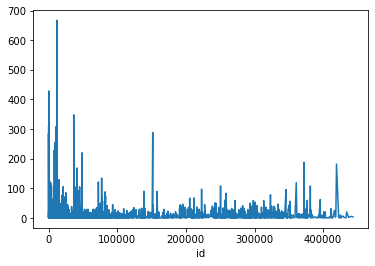

In [10]:
df.success_rating.plot()

In [11]:
df['success'] = (df['success_rating'] > 6.5) * 1

In [12]:
df.sample(5)

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,production_company,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary,release_month,release_day,release_weekday,is_long_movie,ROI,returns,budget_range
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6075,Carlito's Way,0,4.686222,Action Crime Drama Thriller,Al Pacino,Sean Penn,Penelope Ann Miller,63.0,30000000.0,36516012.0,6516012.0,7.7,805.0,UniversalPictures EpicProductions Bregman/Baer...,UnitedStatesofAmerica,"A Puerto-Rican ex-con, just released from pris...",8.698509,144.0,0,1993-11-10,1993,tt0106519,UniversalPictures,0,0,1,0,0,1,1,0,0,1,0,0,0,11,10,Wednesday,1,1.217200,avg,high
56601,The Perfect Game,0,0.977506,Drama Family,Clifton Collins Jr,Cheech Marin,Moisés Arias,18.0,12500000.0,3878993.0,-8621007.0,6.3,31.0,HighRoadEntertainment PreludePictures LoneRunn...,UnitedStatesofAmerica,"Based on a true story, a group of boys from Mo...",1.830829,118.0,0,2010-04-01,2010,tt0473102,HighRoadEntertainment,0,0,1,0,0,0,0,0,0,0,0,0,0,4,1,Thursday,0,0.310319,avg,avg
28211,Chloe,0,1.663693,Drama Thriller Mystery,Julianne Moore,Liam Neeson,Amanda Seyfried,19.0,15000000.0,8459458.0,-6540542.0,5.9,514.0,"StudioCanal MontecitoPictureCompany,The Outpos...",France UnitedStatesofAmerica Canada,A doctor hires an escort to seduce her husband...,10.445867,96.0,0,2009-03-25,2009,tt1352824,StudioCanal,0,0,1,0,0,1,0,0,0,0,1,0,0,3,25,Wednesday,0,0.563964,avg,avg
14048,Man on Wire,0,1.386552,Thriller Documentary Crime History,Philippe Petit,Jean François Heckel,Jean-Louis Blondeau,8.0,8000000.0,2957978.0,-5042022.0,7.5,282.0,UKFilmCouncil RedBoxFilms DiscoveryFilms BBCSt...,UnitedKingdom UnitedStatesofAmerica,"On August 7th 1974, French tightrope walker Ph...",8.359021,94.0,0,2008-07-25,2008,tt1155592,UKFilmCouncil,0,0,0,0,0,1,1,0,0,0,0,0,1,7,25,Friday,0,0.369747,avg,low
254578,Phoenix,0,1.273789,Drama,Nina Hoss,Ronald Zehrfeld,Nina Kunzendorf,21.0,8000000.0,3184472.0,-4815528.0,6.4,147.0,SchrammFilmKoerner&Weber Arte Tempus Westdeuts...,Germany Poland,"A disfigured concentration-camp survivor, unre...",5.298121,98.0,0,2014-09-25,2014,tt2764784,SchrammFilmKoerner&Weber,0,0,1,0,0,0,0,0,0,0,0,0,0,9,25,Thursday,0,0.398059,avg,low


In [13]:
def train_validate_test_split(df):
    ''' 
    This function takes in a dataframe and splits it 80:20.  The 20% will be our testing datafrme for our final model.  The 80% will be split a second time (70:30), creating our final training dataframe and a dataframe to validate our model with before testing.  Leaving us we a Train (56%), Validate(24%) and Test (20%) Dataframe from our original data (100%)
    '''
    
    train, test = train_test_split(df, 
                               train_size = 0.8,
                               random_state=1313)
    
    
    train, validate = train_test_split(train,
                                  train_size = 0.7,
                                  random_state=1313)
    
    
    return train, validate, test


train, validate, test = train_validate_test_split(df)

train.shape, validate.shape, test.shape

((3876, 43), (1662, 43), (1385, 43))

# Scaling and One Hot Encoding

In [14]:
# Scaling
# Columns to be scaled: 
scaler = MinMaxScaler()


In [15]:
# One Hot Encode for Genres

# df['is_genre_adventure'] = df.genres.apply(lambda genre_list: 'Adventure' in genre_list)
# df['is_genre_horror'] = df.genres.apply(lambda genre_list: 'Horror' in genre_list)
# df['is_genre_drama'] = df.genres.apply(lambda genre_list: 'Drama' in genre_list)
# df['is_genre_scifi'] = df.genres.apply(lambda genre_list: 'Science' in genre_list)
# df['is_genre_romance'] = df.genres.apply(lambda genre_list: 'Romance' in genre_list)
# df['is_genre_thriller'] = df.genres.apply(lambda genre_list: 'Thriller' in genre_list)
# df['is_genre_crime'] = df.genres.apply(lambda genre_list: 'Crime' in genre_list)
# df['is_genre_comedy'] = df.genres.apply(lambda genre_list: 'Comedy' in genre_list)
# df['is_genre_animation'] = df.genres.apply(lambda genre_list: 'Animation' in genre_list)
# df['is_genre_action'] = df.genres.apply(lambda genre_list: 'Action' in genre_list)
# df['is_genre_mystery'] = df.genres.apply(lambda genre_list: 'Mystery' in genre_list)
# df['is_genre_fantasy'] = df.genres.apply(lambda genre_list: 'Fantasy' in genre_list)
# df['is_genre_documentary'] = df.genres.apply(lambda genre_list: 'Documentary' in genre_list)

In [16]:
# One Hot Encode Production Company


In [17]:
df.production_company.value_counts()

UniversalPictures                                                  400
ParamountPictures                                                  386
TwentiethCenturyFoxFilmCorporation                                 291
ColumbiaPictures                                                   235
NewLineCinema                                                      187
WarnerBros.                                                        162
WaltDisneyPictures                                                 146
Metro-Goldwyn-Mayer(MGM)                                           109
ColumbiaPicturesCorporation                                        105
UnitedArtists                                                      101
MiramaxFilms                                                        97
TriStarPictures                                                     96
VillageRoadshowPictures                                             74
FoxSearchlightPictures                                              68
DreamW

In [18]:
# Variables for constructing models
x_train = train.drop(columns=['success', 'revenue', 'vote_average', 'success_rating'])
y_train = train.success

x_validate = validate.drop(columns=['success', 'revenue', 'vote_average', 'success_rating'])
y_validate = validate.success

x_test = test.drop(columns=['success', 'revenue', 'vote_average', 'success_rating'])
y_test = test.success

In [19]:
train.success.value_counts()

0    2324
1    1552
Name: success, dtype: int64

In [20]:
# Now that our training sample is ready, lets set up a baseline accuracy to improve upon
train['baseline'] = 0

baseline_accuracy = (train.baseline == train.success).mean()
print(f'Our baseline accuracy is {baseline_accuracy: .2%}')


Our baseline accuracy is  59.96%


In [21]:
# # Random Forest #

# # Make the Model
# forest = RandomForestClassifier(max_depth=10, min_samples_leaf=3, random_state=1313)

# # Fit the Model
# forest.fit(x_train, y_train)

# # Use the Model
# y_pred = forest.predict(x_train)


# performance = classification_report(y_train, y_pred, output_dict=True)

# # Classification Report
# pd.DataFrame(performance).transpose()

In [22]:
# Logistic Regression

# Make the Model
logit = LogisticRegression(C=10, random_state=1313)

# Select the Features we want focused on
features = ['runtime', 'budget']

# Fit the Model
logit.fit(x_train[features], y_train)

# Predictions
y_pred = logit.predict(x_train[features])

# Model Score
m_score = logit.score(x_train[features], y_train)

performance = classification_report(y_train, y_pred, output_dict=True, zero_division=0)

# Classification Report
pd.DataFrame(performance).transpose()


,precision,recall,f1-score,support
0,0.599587,1.000000,0.749677,2324.000000
1,0.000000,0.000000,0.000000,1552.000000
accuracy,0.599587,0.599587,0.599587,0.599587
macro avg,0.299794,0.500000,0.374839,3876.000000
weighted avg,0.359505,0.599587,0.449497,3876.000000


### Test different target variables

In [23]:
df_copy = df.copy()

In [24]:
df_copy.head(1)

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,production_company,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary,release_month,release_day,release_weekday,is_long_movie,ROI,returns,budget_range
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,Four Rooms,0,3.49375,Crime Comedy,Tim Roth,Antonio Banderas,Jennifer Beals,24.0,4000000.0,4300000.0,300000.0,6.5,539.0,MiramaxFilms ABandApart,UnitedStatesofAmerica,It's Ted the Bellhop's first night on the job....,9.026586,98.0,0,1995-12-09,1995,tt0113101,MiramaxFilms,0,0,0,0,0,0,1,1,0,0,0,0,0,12,9,Saturday,0,1.075,avg,low


In [25]:
df_copy['success'] = (df_copy['success_rating'] > 6.5)
df_copy['success'].value_counts(normalize=True)

False    0.600173
True     0.399827
Name: success, dtype: float64

In [26]:
df_copy['success'] = (df_copy['success_rating'] > 7)
df_copy['success'].value_counts(normalize=True)

False    0.625163
True     0.374837
Name: success, dtype: float64

In [27]:
df_copy['success'] = (df_copy['success_rating'] > 7.5)
df_copy['success'].value_counts(normalize=True)

False    0.645529
True     0.354471
Name: success, dtype: float64

In [28]:
df_copy['success'] = (df_copy['success_rating'] > 8.5)
df_copy['success'].value_counts(normalize=True)

False    0.682363
True     0.317637
Name: success, dtype: float64

In [29]:
df_copy['success'] = (df_copy['success_rating'] > 9)
df_copy['success'].value_counts(normalize=True)

False    0.697819
True     0.302181
Name: success, dtype: float64

In [30]:
df_copy['success'] = (df_copy['success_rating'] > 10)
df_copy['success'].value_counts(normalize=True)

False    0.725697
True     0.274303
Name: success, dtype: float64

In [31]:
df_copy['success'] = (df_copy['success_rating'] > 12)
df_copy['success'].value_counts(normalize=True)

False    0.773653
True     0.226347
Name: success, dtype: float64

<AxesSubplot:xlabel='id'>

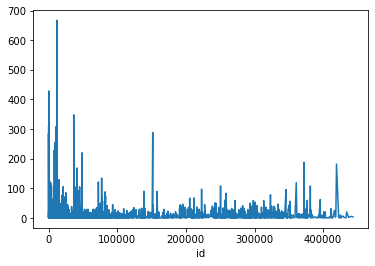

In [32]:
df_copy['success'] = (df_copy['success_rating'] > 6.5) * 1

df_copy.success_rating.plot()

In [33]:
# TAKEAWAYS/NOTES #
# Anything over 9 would need to have had either made more than double the budget, or get close to a perfect rating
# 

In [34]:
df[df.success == 1].total_n_cast.sort_values(ascending=False).head(15).mean()

178.53333333333333

In [35]:
df[df.success == 1].runtime.sort_values(ascending=False).head(10).mean()

234.9

In [36]:
df[df.success == 1].runtime.sort_values(ascending=False).head(50).mean()

195.34

In [37]:
df[df.success == 1].runtime.sort_values(ascending=False).head(100).mean()

181.18

# Dive Deeper
- Genre percentages
- Rule Sets for different movies/genres/production companies
- Insights gained from model

In [38]:
genre_list = ['is_genre_adventure', 'is_genre_horror',
       'is_genre_drama', 'is_genre_scifi', 'is_genre_romance',
       'is_genre_thriller', 'is_genre_crime', 'is_genre_comedy',
       'is_genre_animation', 'is_genre_action', 'is_genre_mystery',
       'is_genre_fantasy', 'is_genre_documentary']

In [39]:
# how much of the data is adventure
df.is_genre_adventure.value_counts(normalize=True)

0    0.843565
1    0.156435
Name: is_genre_adventure, dtype: float64

In [40]:
df[df.success == 1].is_genre_adventure.value_counts(normalize=True)

0    0.80672
1    0.19328
Name: is_genre_adventure, dtype: float64

In [41]:
for genre in df[genre_list]:
    print(df[genre].value_counts(normalize=True))
    print('----------------------------')
    

0    0.843565
1    0.156435
Name: is_genre_adventure, dtype: float64
----------------------------
0    0.896721
1    0.103279
Name: is_genre_horror, dtype: float64
----------------------------
0    0.501083
1    0.498917
Name: is_genre_drama, dtype: float64
----------------------------
0    0.895421
1    0.104579
Name: is_genre_scifi, dtype: float64
----------------------------
0    0.805287
1    0.194713
Name: is_genre_romance, dtype: float64
----------------------------
0    0.738986
1    0.261014
Name: is_genre_thriller, dtype: float64
----------------------------
0    0.847754
1    0.152246
Name: is_genre_crime, dtype: float64
----------------------------
0    0.647552
1    0.352448
Name: is_genre_comedy, dtype: float64
----------------------------
0    0.947566
1    0.052434
Name: is_genre_animation, dtype: float64
----------------------------
0    0.75762
1    0.24238
Name: is_genre_action, dtype: float64
----------------------------
0    0.921277
1    0.078723
Name: is_genre_mys

In [42]:
for genre in df[genre_list]:
    print(df[df.success == 1][genre].value_counts(normalize=True))

0    0.80672
1    0.19328
Name: is_genre_adventure, dtype: float64
0    0.895592
1    0.104408
Name: is_genre_horror, dtype: float64
0    0.544798
1    0.455202
Name: is_genre_drama, dtype: float64
0    0.892702
1    0.107298
Name: is_genre_scifi, dtype: float64
0    0.805636
1    0.194364
Name: is_genre_romance, dtype: float64
0    0.738801
1    0.261199
Name: is_genre_thriller, dtype: float64
0    0.843931
1    0.156069
Name: is_genre_crime, dtype: float64
0    0.638728
1    0.361272
Name: is_genre_comedy, dtype: float64
0    0.932442
1    0.067558
Name: is_genre_animation, dtype: float64
0    0.739523
1    0.260477
Name: is_genre_action, dtype: float64
0    0.921604
1    0.078396
Name: is_genre_mystery, dtype: float64
0    0.901012
1    0.098988
Name: is_genre_fantasy, dtype: float64
0    0.991691
1    0.008309
Name: is_genre_documentary, dtype: float64


<AxesSubplot:>

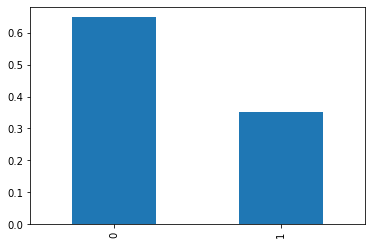

In [43]:
# how much of the data is comedy
df.is_genre_comedy.value_counts(normalize=True).plot.bar()

In [44]:
# how much of the data is drama
df.is_genre_drama.value_counts(normalize=True)

0    0.501083
1    0.498917
Name: is_genre_drama, dtype: float64

In [45]:
df.is_genre_horror.value_counts(normalize=True)

0    0.896721
1    0.103279
Name: is_genre_horror, dtype: float64

In [46]:
df.is_genre_thriller.value_counts(normalize=True)

0    0.738986
1    0.261014
Name: is_genre_thriller, dtype: float64

In [47]:
df.is_genre_action.value_counts(normalize=True)

0    0.75762
1    0.24238
Name: is_genre_action, dtype: float64

In [48]:
df[df.success == 1].budget.sort_values()

id
1939        1020000.0
94329       1100000.0
33061       1100000.0
11462       1103000.0
31526       1114000.0
56164       1180280.0
36685       1200000.0
176         1200000.0
500         1200000.0
24924       1200000.0
429         1200000.0
176124      1200000.0
24153       1200000.0
845         1200000.0
11319       1200000.0
24128       1200000.0
2671        1200000.0
20770       1200000.0
11219       1200000.0
16220       1200000.0
43884       1200000.0
17058       1202007.0
29244       1243000.0
43266       1250000.0
28580       1250000.0
19997       1250000.0
1643        1250000.0
23730       1250000.0
9725        1250000.0
14554       1271000.0
223         1288000.0
192558      1300000.0
488         1300000.0
103         1300000.0
43881       1300000.0
25188       1300000.0
13986       1300000.0
11951       1300000.0
31626       1333333.0
27367       1344000.0
100         1350000.0
16442       1400000.0
117691      1400000.0
19703       1400000.0
521         1400000.0
3309   

In [49]:
df.head()

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,production_company,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary,release_month,release_day,release_weekday,is_long_movie,ROI,returns,budget_range
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,Four Rooms,0,3.493750,Crime Comedy,Tim Roth,Antonio Banderas,Jennifer Beals,24.0,4000000.0,4300000.0,300000.0,6.5,539.0,MiramaxFilms ABandApart,UnitedStatesofAmerica,It's Ted the Bellhop's first night on the job....,9.026586,98.0,0,1995-12-09,1995,tt0113101,MiramaxFilms,0,0,0,0,0,0,1,1,0,0,0,0,0,12,9,Saturday,0,1.075000,avg,low
6,Judgment Night,0,4.854775,Action Thriller Crime,Emilio Estevez,Cuba Gooding Jr.,Denis Leary,15.0,8000000.0,12136938.0,4136938.0,6.4,79.0,UniversalPictures LargoEntertainment JVCEntert...,Japan UnitedStatesofAmerica,"While racing to a boxing match, Frank, Mike, J...",5.538671,110.0,0,1993-10-15,1993,tt0107286,UniversalPictures,0,0,0,0,0,1,1,0,0,1,0,0,0,10,15,Friday,0,1.517117,high,low
11,Star Wars,1,285.487448,Adventure Action Science Fiction,Mark Hamill,Harrison Ford,Carrie Fisher,106.0,11000000.0,775398007.0,764398007.0,8.1,6778.0,Lucasfilm TwentiethCenturyFoxFilmCorporation,UnitedStatesofAmerica,Princess Leia is captured and held hostage by ...,42.149697,121.0,1,1977-05-25,1977,tt0076759,Lucasfilm,1,0,0,1,0,0,0,0,0,1,0,0,0,5,25,Wednesday,1,70.490728,very high,avg
12,Finding Nemo,1,38.013564,Animation Family,Albert Brooks,Ellen DeGeneres,Alexander Gould,24.0,94000000.0,940335536.0,846335536.0,7.6,6292.0,PixarAnimationStudios,UnitedStatesofAmerica,"Nemo, an adventurous young clownfish, is unexp...",25.497794,100.0,1,2003-05-30,2003,tt0266543,PixarAnimationStudios,0,0,0,0,0,0,0,0,1,0,0,0,0,5,30,Friday,0,10.003570,very high,very high
13,Forrest Gump,1,50.537748,Comedy Drama Romance,Tom Hanks,Robin Wright,Gary Sinise,66.0,55000000.0,677945399.0,622945399.0,8.2,8147.0,ParamountPictures,UnitedStatesofAmerica,A man with a low IQ has accomplished great thi...,48.307194,142.0,1,1994-07-06,1994,tt0109830,ParamountPictures,0,0,1,0,1,0,0,1,0,0,0,0,0,7,6,Wednesday,1,12.326280,very high,very high


In [50]:
df[df.success_rating != 0].success_rating.sort_values(ascending=True).head(5)

id
47168     3.062500e-07
274253    3.125000e-07
218275    3.500000e-07
45864     3.687500e-07
48787     4.000000e-07
Name: success_rating, dtype: float64

In [51]:
df['ROI'] = df.revenue / df.budget
df.head()

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,production_company,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary,release_month,release_day,release_weekday,is_long_movie,ROI,returns,budget_range
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,Four Rooms,0,3.493750,Crime Comedy,Tim Roth,Antonio Banderas,Jennifer Beals,24.0,4000000.0,4300000.0,300000.0,6.5,539.0,MiramaxFilms ABandApart,UnitedStatesofAmerica,It's Ted the Bellhop's first night on the job....,9.026586,98.0,0,1995-12-09,1995,tt0113101,MiramaxFilms,0,0,0,0,0,0,1,1,0,0,0,0,0,12,9,Saturday,0,1.075000,avg,low
6,Judgment Night,0,4.854775,Action Thriller Crime,Emilio Estevez,Cuba Gooding Jr.,Denis Leary,15.0,8000000.0,12136938.0,4136938.0,6.4,79.0,UniversalPictures LargoEntertainment JVCEntert...,Japan UnitedStatesofAmerica,"While racing to a boxing match, Frank, Mike, J...",5.538671,110.0,0,1993-10-15,1993,tt0107286,UniversalPictures,0,0,0,0,0,1,1,0,0,1,0,0,0,10,15,Friday,0,1.517117,high,low
11,Star Wars,1,285.487448,Adventure Action Science Fiction,Mark Hamill,Harrison Ford,Carrie Fisher,106.0,11000000.0,775398007.0,764398007.0,8.1,6778.0,Lucasfilm TwentiethCenturyFoxFilmCorporation,UnitedStatesofAmerica,Princess Leia is captured and held hostage by ...,42.149697,121.0,1,1977-05-25,1977,tt0076759,Lucasfilm,1,0,0,1,0,0,0,0,0,1,0,0,0,5,25,Wednesday,1,70.490728,very high,avg
12,Finding Nemo,1,38.013564,Animation Family,Albert Brooks,Ellen DeGeneres,Alexander Gould,24.0,94000000.0,940335536.0,846335536.0,7.6,6292.0,PixarAnimationStudios,UnitedStatesofAmerica,"Nemo, an adventurous young clownfish, is unexp...",25.497794,100.0,1,2003-05-30,2003,tt0266543,PixarAnimationStudios,0,0,0,0,0,0,0,0,1,0,0,0,0,5,30,Friday,0,10.003570,very high,very high
13,Forrest Gump,1,50.537748,Comedy Drama Romance,Tom Hanks,Robin Wright,Gary Sinise,66.0,55000000.0,677945399.0,622945399.0,8.2,8147.0,ParamountPictures,UnitedStatesofAmerica,A man with a low IQ has accomplished great thi...,48.307194,142.0,1,1994-07-06,1994,tt0109830,ParamountPictures,0,0,1,0,1,0,0,1,0,0,0,0,0,7,6,Wednesday,1,12.326280,very high,very high


In [52]:
df['returns'] = pd.qcut(df.ROI, 4, labels=['low', 'avg', 'high', 'very high'])
df['budget_range'] = pd.qcut(df.budget, 5, labels=['low', 'avg', 'high', 'very high'], duplicates='drop')
df.head()

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,production_company,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary,release_month,release_day,release_weekday,is_long_movie,ROI,returns,budget_range
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,Four Rooms,0,3.493750,Crime Comedy,Tim Roth,Antonio Banderas,Jennifer Beals,24.0,4000000.0,4300000.0,300000.0,6.5,539.0,MiramaxFilms ABandApart,UnitedStatesofAmerica,It's Ted the Bellhop's first night on the job....,9.026586,98.0,0,1995-12-09,1995,tt0113101,MiramaxFilms,0,0,0,0,0,0,1,1,0,0,0,0,0,12,9,Saturday,0,1.075000,avg,low
6,Judgment Night,0,4.854775,Action Thriller Crime,Emilio Estevez,Cuba Gooding Jr.,Denis Leary,15.0,8000000.0,12136938.0,4136938.0,6.4,79.0,UniversalPictures LargoEntertainment JVCEntert...,Japan UnitedStatesofAmerica,"While racing to a boxing match, Frank, Mike, J...",5.538671,110.0,0,1993-10-15,1993,tt0107286,UniversalPictures,0,0,0,0,0,1,1,0,0,1,0,0,0,10,15,Friday,0,1.517117,high,low
11,Star Wars,1,285.487448,Adventure Action Science Fiction,Mark Hamill,Harrison Ford,Carrie Fisher,106.0,11000000.0,775398007.0,764398007.0,8.1,6778.0,Lucasfilm TwentiethCenturyFoxFilmCorporation,UnitedStatesofAmerica,Princess Leia is captured and held hostage by ...,42.149697,121.0,1,1977-05-25,1977,tt0076759,Lucasfilm,1,0,0,1,0,0,0,0,0,1,0,0,0,5,25,Wednesday,1,70.490728,very high,avg
12,Finding Nemo,1,38.013564,Animation Family,Albert Brooks,Ellen DeGeneres,Alexander Gould,24.0,94000000.0,940335536.0,846335536.0,7.6,6292.0,PixarAnimationStudios,UnitedStatesofAmerica,"Nemo, an adventurous young clownfish, is unexp...",25.497794,100.0,1,2003-05-30,2003,tt0266543,PixarAnimationStudios,0,0,0,0,0,0,0,0,1,0,0,0,0,5,30,Friday,0,10.003570,very high,very high
13,Forrest Gump,1,50.537748,Comedy Drama Romance,Tom Hanks,Robin Wright,Gary Sinise,66.0,55000000.0,677945399.0,622945399.0,8.2,8147.0,ParamountPictures,UnitedStatesofAmerica,A man with a low IQ has accomplished great thi...,48.307194,142.0,1,1994-07-06,1994,tt0109830,ParamountPictures,0,0,1,0,1,0,0,1,0,0,0,0,0,7,6,Wednesday,1,12.326280,very high,very high


In [53]:
df[df.budget_range == 'low'].success.value_counts(normalize=True)

0    0.668856
1    0.331144
Name: success, dtype: float64

In [113]:
df[(df.budget_range == 'low') & (df.ROI > 1)].ROI.mean()

6.619718513811119

In [55]:
df[df.budget_range == 'very high'].budget.describe()

count    1.250000e+03
mean     8.857996e+07
std      4.690593e+07
min      4.060000e+07
25%      5.500000e+07
50%      7.225000e+07
75%      1.050000e+08
max      3.800000e+08
Name: budget, dtype: float64

In [56]:
df.ROI.sort_values().tail(10)

id
9427       73.671463
8346       73.748809
601        75.520507
176        86.593058
11224      90.893591
36685      94.076932
151743     94.545455
770       100.044115
408       124.242561
12092     190.666667
Name: ROI, dtype: float64

In [57]:
df.head()

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,production_company,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary,release_month,release_day,release_weekday,is_long_movie,ROI,returns,budget_range
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,Four Rooms,0,3.493750,Crime Comedy,Tim Roth,Antonio Banderas,Jennifer Beals,24.0,4000000.0,4300000.0,300000.0,6.5,539.0,MiramaxFilms ABandApart,UnitedStatesofAmerica,It's Ted the Bellhop's first night on the job....,9.026586,98.0,0,1995-12-09,1995,tt0113101,MiramaxFilms,0,0,0,0,0,0,1,1,0,0,0,0,0,12,9,Saturday,0,1.075000,avg,low
6,Judgment Night,0,4.854775,Action Thriller Crime,Emilio Estevez,Cuba Gooding Jr.,Denis Leary,15.0,8000000.0,12136938.0,4136938.0,6.4,79.0,UniversalPictures LargoEntertainment JVCEntert...,Japan UnitedStatesofAmerica,"While racing to a boxing match, Frank, Mike, J...",5.538671,110.0,0,1993-10-15,1993,tt0107286,UniversalPictures,0,0,0,0,0,1,1,0,0,1,0,0,0,10,15,Friday,0,1.517117,high,low
11,Star Wars,1,285.487448,Adventure Action Science Fiction,Mark Hamill,Harrison Ford,Carrie Fisher,106.0,11000000.0,775398007.0,764398007.0,8.1,6778.0,Lucasfilm TwentiethCenturyFoxFilmCorporation,UnitedStatesofAmerica,Princess Leia is captured and held hostage by ...,42.149697,121.0,1,1977-05-25,1977,tt0076759,Lucasfilm,1,0,0,1,0,0,0,0,0,1,0,0,0,5,25,Wednesday,1,70.490728,very high,avg
12,Finding Nemo,1,38.013564,Animation Family,Albert Brooks,Ellen DeGeneres,Alexander Gould,24.0,94000000.0,940335536.0,846335536.0,7.6,6292.0,PixarAnimationStudios,UnitedStatesofAmerica,"Nemo, an adventurous young clownfish, is unexp...",25.497794,100.0,1,2003-05-30,2003,tt0266543,PixarAnimationStudios,0,0,0,0,0,0,0,0,1,0,0,0,0,5,30,Friday,0,10.003570,very high,very high
13,Forrest Gump,1,50.537748,Comedy Drama Romance,Tom Hanks,Robin Wright,Gary Sinise,66.0,55000000.0,677945399.0,622945399.0,8.2,8147.0,ParamountPictures,UnitedStatesofAmerica,A man with a low IQ has accomplished great thi...,48.307194,142.0,1,1994-07-06,1994,tt0109830,ParamountPictures,0,0,1,0,1,0,0,1,0,0,0,0,0,7,6,Wednesday,1,12.326280,very high,very high


In [120]:
df[df.title == 'Star Wars']

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,production_company,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary,release_month,release_day,release_weekday,is_long_movie,ROI,returns,budget_range
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11,Star Wars,1,285.487448,Adventure Action Science Fiction,Mark Hamill,Harrison Ford,Carrie Fisher,106.0,11000000.0,775398007.0,764398007.0,8.1,6778.0,Lucasfilm TwentiethCenturyFoxFilmCorporation,UnitedStatesofAmerica,Princess Leia is captured and held hostage by ...,42.149697,121.0,1,1977-05-25,1977,tt0076759,Lucasfilm,1,0,0,1,0,0,0,0,0,1,0,0,0,5,25,Wednesday,1,70.490728,very high,avg


# Budget Tier Breakdown

In [118]:
budget_tier = {'Budget Tier': ['Low', 'Avg', 'High', 'Very High'], 'Budget Range(Millions)': ['$1.02 - 8', '$8.05 - 15', '$15.05 - 36', '$36.5 - 380'], 'Average ROI': ['6.62%', '5.26%', '3.83%', '3.20%'], 'Max ROI': ['190.66%', '75.52%', '29.91%', '17.5%']}

In [119]:
bt = pd.DataFrame(budget_tier)
bt = bt.groupby('Budget Tier', as_index=True)
bt.head()

,Budget Tier,Budget Range(Millions),Average ROI,Max ROI
0,Low,$1.02 - 8,6.62%,190.66%
1,Avg,$8.05 - 15,5.26%,75.52%
2,High,$15.05 - 36,3.83%,29.91%
3,Very High,$36.5 - 380,3.20%,17.5%


#### Low Budget

In [61]:
# Cast 1
df[df.budget_range == 'low'].cast_actor_1.value_counts().head(10)

Clint Eastwood    19
John Wayne        16
Chuck Norris      14
Paul Newman       12
Ethan Hawke       12
Woody Allen       11
Gene Hackman      10
Sean Connery      10
Robert De Niro    10
Mel Gibson         9
Name: cast_actor_1, dtype: int64

In [62]:
# Cast 2
df[df.budget_range == 'low'].cast_actor_2.value_counts().head()

Susan Sarandon      8
Diane Keaton        8
Jamie Lee Curtis    7
Evan Rachel Wood    5
Juliette Binoche    5
Name: cast_actor_2, dtype: int64

In [63]:
# Cast 3
df[df.budget_range == 'low'].cast_actor_3.value_counts().head()

Anna Faris       6
Brian Dennehy    5
Jeremy Irons     5
Jared Harris     4
Bill Pullman     4
Name: cast_actor_3, dtype: int64

In [64]:
df[df.budget_range == 'low'].cast_actor_1.value_counts().tail(5)

Angelina Jolie            1
Peter Liapis              1
Jonathan Velasquez        1
Catherine Mary Stewart    1
Florence Hartigan         1
Name: cast_actor_1, dtype: int64

In [65]:
# Percent that we consider successful
df[df.budget_range == 'low'].success.value_counts(normalize=True)

0    0.668856
1    0.331144
Name: success, dtype: float64

In [66]:
# Runtime
df[(df.budget_range == 'low') & (df.success == 1) & (df.ROI > 10)].runtime.mean()

108.40948275862068

In [67]:
# Cast Size
df[(df.budget_range == 'low') & (df.success == 1) & (df.ROI > 10)].total_n_cast.mean()

21.474137931034484

In [68]:
# Genres
low_copy = df[(df.budget_range == 'low') & (df.success == 1) & (df.ROI > 10)]
low_copy.is_genre_drama.value_counts(normalize=True)

0    0.50431
1    0.49569
Name: is_genre_drama, dtype: float64

In [69]:
low_copy.is_genre_comedy.value_counts(normalize=True)

0    0.676724
1    0.323276
Name: is_genre_comedy, dtype: float64

In [70]:
low_copy.is_genre_horror.value_counts(normalize=True)

0    0.836207
1    0.163793
Name: is_genre_horror, dtype: float64

In [71]:
low_copy.is_genre_thriller.value_counts(normalize=True)

0    0.741379
1    0.258621
Name: is_genre_thriller, dtype: float64

In [72]:
# 
low_copy.cast_actor_3.mode()

0          Burt Young
1         Dan Aykroyd
2       Harvey Keitel
3      Katharine Ross
4     Sergei Bezrukov
5    Shirley MacLaine
6    Vincent Gardenia
7       William Zabka
dtype: object

#### Avg Budget

In [73]:
df[df.budget_range == 'avg'].cast_actor_1.value_counts().head()

Robin Williams           5
Naomi Watts              5
Colin Farrell            5
Bill Murray              5
Arnold Schwarzenegger    5
Name: cast_actor_1, dtype: int64

In [74]:
df[df.budget_range == 'avg'].cast_actor_2.value_counts().head()

Danny DeVito      4
Robert De Niro    4
Dom DeLuise       3
Claire Danes      3
Matt Damon        3
Name: cast_actor_2, dtype: int64

In [75]:
df[df.budget_range == 'avg'].cast_actor_3.value_counts().head()

Christina Applegate    3
Dennis Hopper          3
Gwyneth Paltrow        3
Madeline Kahn          2
Allen Payne            2
Name: cast_actor_3, dtype: int64

In [76]:
# Success Rate
df[df.budget_range == 'avg'].success.value_counts(normalize=True)

0    0.538182
1    0.461818
Name: success, dtype: float64

In [77]:
# Runtime
df[(df.budget_range == 'avg') & (df.success == 1) & (df.ROI > 10)].runtime.mean()

115.55555555555556

In [78]:
# Cast Size
df[(df.budget_range == 'avg') & (df.success == 1) & (df.ROI > 10)].total_n_cast.mean()

29.72222222222222

In [79]:
avg_copy = df[(df.budget_range == 'avg') & (df.success == 1)]

In [80]:
avg_copy.is_genre_drama.value_counts(normalize=True)

0    0.501312
1    0.498688
Name: is_genre_drama, dtype: float64

In [81]:
avg_copy.is_genre_comedy.value_counts(normalize=True)

0    0.674541
1    0.325459
Name: is_genre_comedy, dtype: float64

In [82]:
avg_copy.is_genre_romance.value_counts(normalize=True)

0    0.80315
1    0.19685
Name: is_genre_romance, dtype: float64

In [83]:
avg_copy.is_genre_scifi.value_counts(normalize=True)

0    0.908136
1    0.091864
Name: is_genre_scifi, dtype: float64

In [84]:
avg_copy.is_genre_action.value_counts(normalize=True)

0    0.813648
1    0.186352
Name: is_genre_action, dtype: float64

In [85]:
avg_copy.is_genre_adventure.value_counts(normalize=True)

0    0.866142
1    0.133858
Name: is_genre_adventure, dtype: float64

#### High Budget

In [86]:
df[df.budget_range == 'high'].cast_actor_1.value_counts().head()

Robert De Niro    14
Jason Statham     13
Nicolas Cage      12
Bruce Willis      12
Keanu Reeves      11
Name: cast_actor_1, dtype: int64

In [87]:
df[df.budget_range == 'high'].cast_actor_2.value_counts().head()

Jennifer Aniston    7
Ben Kingsley        7
Guy Pearce          6
Morgan Freeman      6
Gene Hackman        6
Name: cast_actor_2, dtype: int64

In [88]:
df[df.budget_range == 'high'].cast_actor_3.value_counts().head()

DeForest Kelley     5
Sigourney Weaver    5
Carrie Fisher       4
Paul Giamatti       4
Julianne Moore      4
Name: cast_actor_3, dtype: int64

In [89]:
# Success Rate
df[df.budget_range == 'high'].success.value_counts(normalize=True)

0    0.573716
1    0.426284
Name: success, dtype: float64

In [90]:
# Runtime
df[(df.budget_range == 'high') & (df.success == 1)].runtime.mean()

111.98122065727699

In [91]:
# Cast Size
df[(df.budget_range == 'high') & (df.success == 1)].total_n_cast.mean()

29.24413145539906

In [92]:
high_copy = df[(df.budget_range == 'high') & (df.success == 1)]

In [93]:
high_copy.is_genre_action.value_counts(normalize=True)

0    0.752739
1    0.247261
Name: is_genre_action, dtype: float64

In [94]:
high_copy.is_genre_adventure.value_counts(normalize=True)

0    0.843505
1    0.156495
Name: is_genre_adventure, dtype: float64

In [95]:
high_copy.is_genre_drama.value_counts(normalize=True)

0    0.552426
1    0.447574
Name: is_genre_drama, dtype: float64

In [96]:
high_copy.is_genre_comedy.value_counts(normalize=True)

0    0.597809
1    0.402191
Name: is_genre_comedy, dtype: float64

In [97]:
high_copy.is_genre_horror.value_counts(normalize=True)

0    0.902973
1    0.097027
Name: is_genre_horror, dtype: float64

In [98]:
high_copy.is_genre_romance.value_counts(normalize=True)

0    0.787167
1    0.212833
Name: is_genre_romance, dtype: float64

In [122]:
high_copy.is_genre_scifi.value_counts(normalize=True)

0    0.910798
1    0.089202
Name: is_genre_scifi, dtype: float64

#### Very High Budget

In [100]:
df[df.budget_range == 'very high'].cast_actor_1.value_counts().head()

Tom Cruise           22
Bruce Willis         21
Nicolas Cage         20
Denzel Washington    19
Johnny Depp          19
Name: cast_actor_1, dtype: int64

In [101]:
df[df.budget_range == 'very high'].cast_actor_2.value_counts().head()

Brad Pitt            10
Samuel L. Jackson     9
Charlize Theron       8
Morgan Freeman        8
Rupert Grint          7
Name: cast_actor_2, dtype: int64

In [102]:
df[df.budget_range == 'very high'].cast_actor_3.value_counts().head()

Emma Watson          9
Samuel L. Jackson    9
Cameron Diaz         6
Giovanni Ribisi      5
Brendan Gleeson      5
Name: cast_actor_3, dtype: int64

In [103]:
df[df.budget_range == 'very high'].success.value_counts(normalize=True)

1    0.5112
0    0.4888
Name: success, dtype: float64

In [104]:
# Runtime
df[(df.budget_range == 'very high') & (df.success == 1) & (df.ROI > 3)].runtime.mean()


118.89168765743074

In [125]:
# Cast Size
df[(df.budget_range == 'very high') & (df.success == 1) & (df.ROI > 3)].total_n_cast.mean()

40.0528967254408

In [127]:
vh_copy = df[(df.budget_range == 'very high') & (df.success == 1)]

In [128]:
vh_copy.is_genre_drama.value_counts(normalize=True)

0    0.699531
1    0.300469
Name: is_genre_drama, dtype: float64

In [129]:
vh_copy.is_genre_comedy.value_counts(normalize=True)

0    0.680751
1    0.319249
Name: is_genre_comedy, dtype: float64

In [130]:
vh_copy.is_genre_romance.value_counts(normalize=True)

0    0.879499
1    0.120501
Name: is_genre_romance, dtype: float64

In [131]:
vh_copy.is_genre_animation.value_counts(normalize=True)

0    0.835681
1    0.164319
Name: is_genre_animation, dtype: float64

In [132]:
vh_copy.is_genre_horror.value_counts(normalize=True)

0    0.956182
1    0.043818
Name: is_genre_horror, dtype: float64

In [133]:
vh_copy.is_genre_thriller.value_counts(normalize=True)

0    0.701095
1    0.298905
Name: is_genre_thriller, dtype: float64

In [134]:
vh_copy.is_genre_action.value_counts(normalize=True)

0    0.558685
1    0.441315
Name: is_genre_action, dtype: float64

In [135]:
vh_copy.is_genre_adventure.value_counts(normalize=True)

0    0.591549
1    0.408451
Name: is_genre_adventure, dtype: float64

In [136]:
vh_copy.is_genre_fantasy.value_counts(normalize=True)

0    0.791862
1    0.208138
Name: is_genre_fantasy, dtype: float64

In [ ]:
vh_copy.is_genre_scifi.value_counts(normalize=True)